In [ ]:
import pynini
from nemo_text_processing.text_normalization.en.graph_utils import (
    NEMO_DIGIT,
    NEMO_SIGMA,
    NEMO_SPACE,
    NEMO_WHITE_SPACE,
    GraphFst,
    delete_space,
    insert_space,
)
from nemo_text_processing.text_normalization.pl.graph_utils import PL_ALPHA
from nemo_text_processing.text_normalization.pl.utils import adjective_inflection, get_abs_path, load_labels
from nemo_text_processing.text_normalization.pl.taggers.ordinal import complete_paradigm
from pynini.lib import pynutil


In [3]:
def make_million(number: str, non_zero_pl: 'pynini.FstLike', non_zero_quant: 'pynini.FstLike', case: str = None, deterministic: bool = True) -> 'pynini.FstLike':
    """
    Helper function for thousands/millions/milliards and higher
    Args:
        number: the string of the number
        non_zero_pl: An fst of digits excluding 0, 1, 5-9, to prefix to plural forms (nom/acc)
        non_zero_quant: An fst of digits excluding 0 and 1-4, to prefix to the quantity forms (nom/acc)
        case: the string of the case (if None, nominative/accusative is presumed)
        deterministic: if True, generate a deterministic fst

    Returns:
        graph: A pynini.FstLike object
    """
    if case is None:
        sg_end = ""
        pl_end = "y"
        quant_end = "ów"
        one = "jeden"
    else:
        SG = {
            "loc": "ie",
            "ins": "em",
            "dat": "owi",
            "gen": "a",
        }
        PL = {
            "loc": "ach",
            "ins": "ami",
            "dat": "om",
            "gen": "ów",
        }
        ONE = {
            "loc": "jednym",
            "ins": "jednym",
            "dat": "jednemu",
            "gen": "jednego",
        }
        sg_end = SG[case]
        pl_end = PL[case]
        one = ONE[case]
        quant_end = pl_end
        if case == "loc" and number.endswith("ard"):
            sg_end = "zie"
    graph = pynutil.add_weight(pynini.cross("001", f"{number}{sg_end}"), -0.001)
    if not deterministic:
        graph |= pynutil.add_weight(pynini.cross("001", f"{one} {number}{sg_end}"), -0.001)
    graph |= non_zero_pl + pynutil.insert(f" {number}{pl_end}")
    # hack for the stem change in tysiąc (1000)
    if number == "tysiąc":
        number = "tysięc"
    graph |= non_zero_quant + pynutil.insert(f" {number}{quant_end}")
    graph |= pynutil.delete("000")
    graph += insert_space
    return graph

In [4]:
def make_inflected_graph_dict(file_path: str, cross: str, deterministic=False) -> dict:
    graph_dict = {}
    for line in load_labels(get_abs_path(file_path)):
        key, value = line[0], line[1]
        if key not in graph_dict:
            graph_dict[key] = pynini.cross(cross, value)
        else:
            if not deterministic:
                graph_dict[key] |= pynini.cross(cross, value)
    return graph_dict


def get_nominal_inflections(inflection_file, noun_file):
    output = {}
    inflections = {a[0]: a[1] for a in load_labels(get_abs_path(inflection_file))}
    digit_noun_tsv = load_labels(get_abs_path(noun_file))
    for digit_noun in digit_noun_tsv:
        word = digit_noun[0]
        digit = digit_noun[1]
        lemma_ending = inflections["sg_nom"]
        assert word.endswith(lemma_ending), f"Word {word} does not end with {lemma_ending}"
        stem = word[:-len(lemma_ending)]
        wordforms = {k: stem + v for k, v in inflections.items()}
        output[digit] = wordforms
    return output

In [5]:
def get_nominal_graph(inflection_file, noun_file):
    output = {}
    input = get_nominal_inflections(inflection_file, noun_file)
    for item in input:
        for key in input[item]:
            if not key in output:
                output[key] = pynini.cross(item, input[item][key])
            else:
                output[key] |= pynini.cross(item, input[item][key])
    return output

In [6]:
deterministic = True  # Set to False for non-deterministic graphs

jeden_all = adjective_inflection("jeden")
jeden_graph = pynini.cross("1", jeden_all["mi_sg_nom"])
# in compound numbers, jeden does not inflect
jeden_only = pynini.cross("1", jeden_all["mi_sg_nom"])
if not deterministic:
    for key in jeden_all:
        if key == "mi_sg_nom":
            continue
        jeden_graph |= pynini.cross("1", jeden_all[key])
complete_paradigm(jeden_all)
self_jeden_all = {a[0]: pynini.cross("1", a[1]) for a in jeden_all.items()}
self_zero_all = get_nominal_graph("data/grammar/noun_nt_ro.tsv", "data/numbers/zero.tsv")
self_zero_all = get_nominal_graph("data/grammar/noun_nt_ro.tsv", "data/numbers/zero.tsv")

cases = ["nom", "gen", "dat", "acc", "ins", "loc", "voc"]
jeden_filt = {}
for case in cases:
    jeden_filt[case] = jeden_all[f'mi_sg_{case}']
tysiac_forms = {a[0]: a[1] for a in load_labels(get_abs_path("data/numbers/tysiac.tsv"))}

- jeden_filt

In [16]:
zero_sg = {x.replace("sg_", ""): y for x, y in self_zero_all.items() if x.startswith("sg_")}

In [17]:
zero_sg

{'nom': <vector Fst at 0x799b5b4f6ab0>,
 'gen': <vector Fst at 0x799b5b4f64f0>,
 'dat': <vector Fst at 0x799b5b4f65b0>,
 'acc': <vector Fst at 0x799b5b4f6f30>,
 'ins': <vector Fst at 0x799b5b4f6f70>,
 'loc': <vector Fst at 0x799b5b4f6fb0>,
 'voc': <vector Fst at 0x799b5b4fe030>}

In [8]:
("0" @ self_zero_all["sg_gen"]).string()

'zera'

In [43]:
def get_digit_forms(filename):
    """
    Returns a dictionary of digit forms for Polish numbers.
    """
    output = {}
    for line in load_labels(get_abs_path(filename)):
        digit, grammar, form = line[0], line[1], line[2]
        if not digit in output:
            output[digit] = {}
        if grammar not in output[digit]:
            output[digit][grammar] = form
        else:
            if type(output[digit][grammar]) is list:
                output[digit][grammar].append(form)
            else:
                output[digit][grammar] = [output[digit][grammar], form]
    return output


In [29]:
dd = get_digit_forms()

In [88]:
def dict_to_graph(input_dict: dict, deterministic: bool = True) -> dict:
    """
    Converts a nested dictionary of forms to a dict of pynini.FSTs.
    Example input:
        {'2': {'mi_pl_ins': ['form1', 'form2'], 'mi_sg_nom': 'form3'}}
    Output:
        {'2': {'mi_pl_ins': FST, 'mi_sg_nom': FST}}
    """
    graph_dict = {}
    for key, value in input_dict.items():
        graph_dict[key] = {}
        for subkey, subvalue in value.items():
            if isinstance(subvalue, list):
                graph = pynini.cross(key, subvalue[0])
                if not deterministic:
                    for alt in subvalue[1:]:
                        graph |= pynini.cross(key, alt)
            else:
                graph = pynini.cross(key, subvalue)
            graph_dict[key][subkey] = graph
    return graph_dict

In [39]:
d2 = dict_to_graph(dd, deterministic=True)

In [89]:
cases = ["nom", "gen", "dat", "acc", "ins", "loc", "voc"]
dwa_cases = ["mi_pl_nom", "pl_gen", "pl_dat", "mi_pl_nom", "mi_pl_ins", "pl_gen", "mi_pl_nom"]
pl_cases = ["mi_pl_nom", "pl_gen", "pl_dat", "mi_pl_nom", "pl_ins", "pl_gen", "mi_pl_nom"]
qnt_cases = ["mi_pl_nom", "pl_gen", "pl_gen", "mi_pl_nom", "pl_ins", "pl_gen", "mi_pl_nom"]
jeden_filt = {}
for case in cases:
    jeden_filt[case] = self_jeden_all[f'mi_sg_{case}']
# something similar for dwa
digit_forms_all = get_digit_forms("data/numbers/digit_forms.tsv")
digit_graph = dict_to_graph(digit_forms_all, deterministic=True)
digit_pl = {}
for idx in range(len(cases)):
    digit_pl[cases[idx]] = pynini.union(
        digit_graph["2"][dwa_cases[idx]],
        digit_graph["3"][pl_cases[idx]],
        digit_graph["4"][pl_cases[idx]],
    ).optimize()


In [94]:
("2" @ digit_pl["gen"]).string()
# ("2" @ digit_graph["2"]["pl_dat"]).string()

'dwóch'

In [84]:
("2" @ d2["2"]["mp_pl_nom"]).string()

'dwaj'

In [23]:
for a in load_labels(get_abs_path("data/numbers/digit_forms.tsv")):
    print(a)
a

['2', 'mi_pl_nom', 'dwa']
['2', 'mp_pl_nom', 'dwaj']
['2', 'f_pl_nom', 'dwie']
['2', 'pl_gen', 'dwóch']
['2', 'pl_gen', 'dwu']
['2', 'f_pl_ins', 'dwiema']
['2', 'f_pl_ins', 'dwoma']
['2', 'f_pl_ins', 'dwu']
['2', 'mi_pl_ins', 'dwoma']
['2', 'mi_pl_ins', 'dwu']
['2', 'pl_dat', 'dwóm']
['2', 'pl_dat', 'dwom']
['2', 'pl_dat', 'dwu']
['2', 'compound', 'dwu']
['3', 'mi_pl_nom', 'trzy']
['3', 'mp_pl_nom', 'trzej']
['3', 'pl_gen', 'trzech']
['3', 'mi_pl_ins', 'trzema']
['3', 'pl_dat', 'trzem']
['3', 'compound', 'trzy']
['4', 'mi_pl_nom', 'cztery']
['4', 'mp_pl_nom', 'czterej']
['4', 'pl_gen', 'czterech']
['4', 'mi_pl_ins', 'czterema']
['4', 'pl_dat', 'czterem']
['4', 'compound', 'cztero']
['5', 'mi_pl_nom', 'pięć']
['5', 'mp_pl_nom', 'pięciu']
['5', 'pl_gen', 'pięciu']
['5', 'mi_pl_ins', 'pięcioma']
['5', 'pl_dat', 'pięciu']
['5', 'compound', 'pięcio']


['5', 'compound', 'pięcio']

In [9]:
digit_noun_tsv = load_labels(get_abs_path("data/grammar/noun_nt_ro.tsv"))

In [10]:
noun_labels = [x[0] for x in digit_noun_tsv]

In [11]:
TYS = """
nominative	miliard	miliardy
genitive	miliarda	miliardów
dative	miliardowi	miliardom
accusative	miliard	miliardy
instrumental	miliardem	miliardami
locative	miliardzie	miliardach
vocative	miliardzie	miliardy
"""
sg = []
pl = []
for line in TYS.strip().split("\n"):
    if not "\t" in line:
        continue
    line = line.replace("miliard", "")
    parts = line.split("\t")
    if len(parts) != 3:
        continue
    sg.append(parts[1])
    pl.append(parts[2])
forms = sg + pl


In [12]:
forms

['',
 'a',
 'owi',
 '',
 'em',
 'zie',
 'zie',
 'y',
 'ów',
 'om',
 'y',
 'ami',
 'ach',
 'y']

In [13]:
with open(get_abs_path("data/grammar/noun_mi_d.tsv"), "w") as f:
    for i in zip(noun_labels, forms):
        f.write(f"{i[0]}\t{i[1]}\n")

In [1]:
from nemo_text_processing.text_normalization.pl.taggers.cardinal import CardinalFst

In [2]:
cfst = CardinalFst(deterministic=True)

In [10]:
("1" @ cfst.jeden_all["nt_sg_voc"]).string()

'jedne'

In [11]:
dgt = cfst.get_digits_all(deterministic=False)

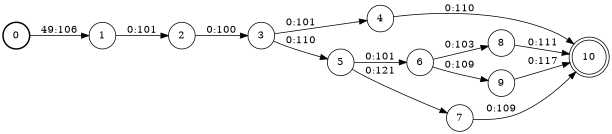

In [13]:
("1" @ dgt["sg"]["gen"]).optimize()